In [1]:
pip install libfmp

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     -------------------------------------- 110.0/110.0 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 18.5/18.5 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.5/2.5 MB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 3.9 MB/s eta 0:00:00
  Created wheel for music21: filename=music21-5.7.2-py3-none-any.whl size=22024606 sha256=994251f29f0f539d185a1f7d1e421a08c58b161df3d7b335acf44140369276f4
  Stored in directory: c:\users\罗晓珂\appdata\local\pip\cache\wheels\42\99\3a\04f08d0c73e8ca2cc1fe4a8ba076154ce20b9976acdc3e859d
Successfully built music21
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.31.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [1]:
import sys
import numpy as np
import librosa, pretty_midi
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import os
import librosa.display
from librosa import util
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
%matplotlib inline

import sys
sys.path.append('..')
# import libfmp.c3

ModuleNotFoundError: No module named 'libfmp'

In [5]:
score_midi = "D:/罗晓珂/Documents/Music-Score Alignment/midi/Chopin_Ballade/Chopin_op38_p01.mid"
perf = "D:/罗晓珂/Documents/Music-Score Alignment/audio/Chopin_Ballade/Chopin_op38_p01"
fs = 44100
stride = 512
n_fft = 4096

n_mels = 138
# onset-detect的参数
fmin = 27.5
fmax = 16000.
lag = 2
max_size = 3

In [6]:
"""参照librosa的方法对envolope进行归一化"""
def nrm_onset_env(onset_envelope):
    onset_envelope = onset_envelope - np.min(onset_envelope)

    # Mypy does not realize that oenv is not None by now
    # Max-scale with safe division
    onset_envelope /= np.max(onset_envelope) + util.tiny(onset_envelope)  # type: ignore
    return onset_envelope

In [7]:
"""
使用librosa.sequence.dtw方法实现DTW
使用的feature为chroma和sx和spectra
"""
# 以MIDI形式获取score
score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
# 获取表演音频
perf,_ = librosa.load(perf + '.wav', sr=fs) 
# 把score和表演都转换为chroma feature
score_chroma = librosa.feature.chroma_stft(y=score_synth, sr=fs, tuning=0, norm=2,
                                           hop_length=stride, n_fft=n_fft)
score_logch = librosa.power_to_db(score_chroma, ref=score_chroma.max())
perf_chroma = librosa.feature.chroma_stft(y=perf, sr=fs, tuning=0, norm=2,
                                          hop_length=stride, n_fft=n_fft)
perf_logch = librosa.power_to_db(perf_chroma, ref=perf_chroma.max())
score_spec = np.abs(librosa.stft(y=score_synth, hop_length=stride, n_fft=n_fft))**2
score_logspec = librosa.power_to_db(score_spec, ref=score_spec.max())
perf_spec = np.abs(librosa.stft(y=perf, hop_length=stride, n_fft=n_fft))**2
perf_logspec = librosa.power_to_db(perf_spec, ref=perf_spec.max())
score_S = librosa.feature.melspectrogram(y=score_synth, sr=fs, n_fft=n_fft,
                                   hop_length=stride,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
score_env = librosa.onset.onset_strength(S=librosa.power_to_db(score_S, ref=np.max),
                                      sr=fs,
                                      hop_length=stride,
                                      lag=lag, max_size=max_size, detrend = True)
perf_S = librosa.feature.melspectrogram(y=perf, sr=fs, n_fft=n_fft,
                                   hop_length=stride,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
perf_env = librosa.onset.onset_strength(S=librosa.power_to_db(perf_S, ref=np.max),
                                      sr=fs,
                                      hop_length=stride,
                                      lag=lag, max_size=max_size, detrend = True)



NameError: name 'perf_env_norm' is not defined

In [8]:
score_env_norm = nrm_onset_env(score_env)
perf_env_norm = nrm_onset_env(perf_env)

In [9]:
# 运行DTW
# D is COST matrix
D1, wp1 = librosa.sequence.dtw(X=score_logch, Y=perf_logch)
D2, wp2 = librosa.sequence.dtw(X=score_logspec, Y=perf_logspec)
D3, wp3 = librosa.sequence.dtw(X=perf_env_norm, Y=score_env_norm)
path1 = np.array(list(reversed(np.asarray(wp1))))
path2 = np.array(list(reversed(np.asarray(wp2))))
path3 = np.array(list(reversed(np.asarray(wp3))))

In [12]:
path3

array([[    0,     0],
       [    1,     1],
       [    2,     2],
       ...,
       [11040, 11434],
       [11041, 11435],
       [11042, 11436]])

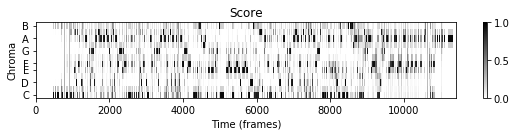

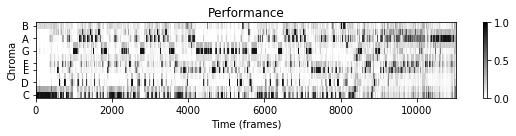

In [13]:
plt.figure(figsize=(8, 2))
plt.title('Score')
librosa.display.specshow(score_chroma , x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=stride)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 2))
plt.title('Performance')
librosa.display.specshow(perf_chroma, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=stride)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()


In [ ]:
plt.figure(figsize=(8, 2))
plt.title('Score')
librosa.display.specshow(score_spec , x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=stride)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 3, 1)
libfmp.c3.plot_matrix_with_points(D1, wp1, linestyle='-',  marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(D1)], 
    title='DTW on Chroma feature', xlabel='Performance', ylabel='Score');

ax = plt.subplot(1, 3, 2)
libfmp.c3.plot_matrix_with_points(D2, wp2, linestyle='-', marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(D2)], 
    title='DTW on Spectro feature', xlabel='Performance', ylabel='Score');

ax = plt.subplot(1, 3, 3)
libfmp.c3.plot_matrix_with_points(D3, wp3, linestyle='-', marker='', 
    ax=[ax], aspect='equal', clim=[0, np.max(D3)], 
    title='DTW on Onset feature', xlabel='Performance', ylabel='Score');

plt.tight_layout()

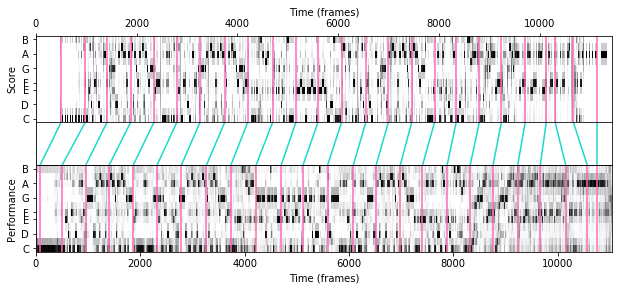

In [32]:
N = score_chroma.shape[1]
M = perf_chroma.shape[1]

plt.figure(figsize=(8, 3))
#plt.figure(figsize=(5, 3)) 
ax_X = plt.axes([0, 0.60, 1, 0.40])
librosa.display.specshow(score_chroma, ax=ax_X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=stride)
ax_X.set_ylabel('Score')
ax_X.set_xlabel('Time (frames)')
ax_X.xaxis.tick_top()
ax_X.xaxis.set_label_position('top') 

ax_Y = plt.axes([0, 0, 1, 0.40])
librosa.display.specshow(perf_chroma, ax=ax_Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=stride)
ax_Y.set_ylabel('Performance')
ax_Y.set_xlabel('Time (frames)')

step = 500
y_min_X, y_max_X = ax_X.get_ylim()
y_min_Y, y_max_Y = ax_Y.get_ylim()
for t in path1[0:-1:step, :]: 
    ax_X.vlines(t[0], y_min_X, y_max_X, color='#FF69B4')
    ax_Y.vlines(t[1], y_min_Y, y_max_Y, color='#FF69B4')

ax = plt.axes([0, 0.40, 1, 0.20])
for p in path1[0:-1:step, :]: 
    ax.plot((p[0]/N, p[1]/M), (1, -1), color=(0.1,0.85,0.8))
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([]);